Loading samples: 100%|██████████| 151/151 [00:17<00:00,  8.48it/s]


Subtitle text:
 one could almost say i was raised to be calvin's lawyer
one could almost say youse a nigger
what did you say
i said
nothing he's just being cheeky
uh anything else about mr
candie that i should know before i meet him
yes he is a bit of a francophile
chuckles what civilized people aren't
and he prefers monsieur candie to mr
candie
speaks french he doesn't speak french
don't speak french to him it'll embarrass him


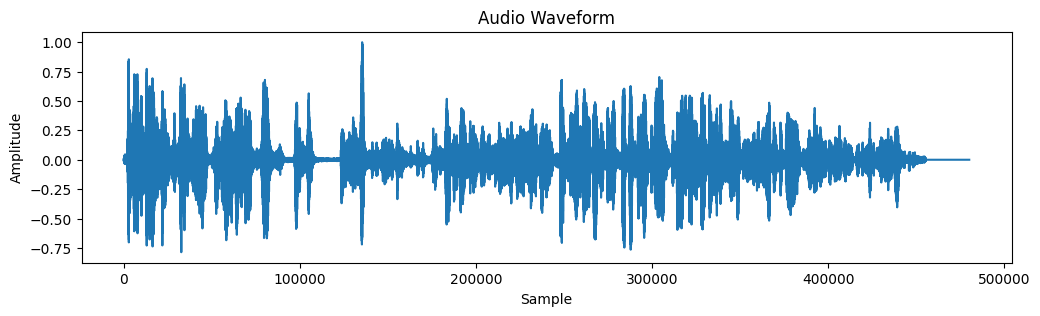

In [1]:
import matplotlib.pyplot as plt
import os
import random
import torchaudio

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple


class MovieSubDataset(Dataset):
    def __init__(self, samples: List[Tuple[str, str]], resample_rate: int = 16_000, show_progress: bool =True):
        self.resample_rate = resample_rate
        self.data = []

        iterator = tqdm(samples, desc="Loading samples") if show_progress else samples

        for wav_path, txt_path in iterator:
            waveform, sample_rate = torchaudio.load(wav_path)
            with open(txt_path, "r", encoding="utf-8") as f:
                subtitle_text = f.read()

            # convert to mono (if stereo) - downmixing
            if waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            # resample to resample_rate
            if sample_rate != self.resample_rate:
                resampler = torchaudio.transforms.Resample(
                    orig_freq=sample_rate, new_freq=self.resample_rate
                )
                waveform = resampler(waveform)
                
            # normalize: scale waveform to [-1, 1] range
            waveform = waveform / waveform.abs().max()
            
            self.data.append((waveform, sample_rate, subtitle_text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def load_movie_subs(root_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Load movie subs dataset, split into train/val/test sets, and return corresponding DataLoaders.

    Parameters
    ----------
    root_dir : str
        Path to the dataset directory containing subdirectories for each movie.
    batch_size : int, optional
        Batch size for the DataLoaders. Default is 64.

    Returns
    -------
    Tuple[DataLoader, DataLoader, DataLoader]
        DataLoaders for training, validation, and test datasets.
    """
    all_samples = []

    for movie_name in os.listdir(root_dir):
        movie_path = os.path.join(root_dir, movie_name)
        if not os.path.isdir(movie_path):
            continue

        for fname in os.listdir(movie_path):
            if fname.endswith(".wav"):
                base = os.path.splitext(fname)[0]
                
                wav_path = os.path.join(movie_path, f"{base}.wav")
                txt_path = os.path.join(movie_path, f"{base}.txt")
                
                if os.path.exists(wav_path) and os.path.exists(txt_path):
                    all_samples.append((wav_path, txt_path))

    # shuffle and split
    random.seed(42)
    random.shuffle(all_samples)

    train_data, temp_data = train_test_split(all_samples, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # create DataLoaders
    train_loader = DataLoader(MovieSubDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(MovieSubDataset(val_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(MovieSubDataset(test_data), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


def main():
    train_loader, validation_loader, test_loader = load_movie_subs("/kaggle/input/movie2sub-dataset/dataset")

    batch = next(iter(train_loader))
    waveform, sample_rate, subtitle = batch[0][0], batch[1][0], batch[2][0]

    print("Subtitle text:\n", subtitle)

    plt.figure(figsize=(12, 3))
    plt.plot(waveform.squeeze().numpy())
    plt.title("Audio Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    

if __name__ == "__main__":
    main()